# MONAI : Tutorial : 2d_registration
## 2D XRay registration demo

参照URL:
- https://github.com/Project-MONAI/tutorials/tree/main/2d_registration
- https://www.classcat.com/medical_ai/2022/11/08/monai-1-0-tutorials-2d-registration-registration-mednist/


## 0. 準備

In [1]:
# パッケージのインポート
import warnings
warnings.simplefilter('ignore')

import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import torch
from torch.nn import MSELoss

from monai.utils import set_determinism, first
from monai.transforms import (
    EnsureChannelFirstD,
    Compose,
    LoadImageD,
    RandRotateD,
    RandZoomD,
    ScaleIntensityRanged,
)
from monai.data import DataLoader, Dataset, CacheDataset
from monai.config import print_config, USE_COMPILED
from monai.networks.nets import GlobalNet
from monai.networks.blocks import Warp
from monai.apps import MedNISTDataset

print_config()

MONAI version: 1.2.dev2302
Numpy version: 1.24.1
Pytorch version: 1.12.0+cu113
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: 708e1a1cf4a1d5516eaf65b8a0bee8887cdee494
MONAI __file__: /home/aska/anaconda3/envs/monai/lib/python3.10/site-packages/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: NOT INSTALLED or UNKNOWN VERSION.
Nibabel version: NOT INSTALLED or UNKNOWN VERSION.
scikit-image version: NOT INSTALLED or UNKNOWN VERSION.
Pillow version: 9.4.0
Tensorboard version: NOT INSTALLED or UNKNOWN VERSION.
gdown version: NOT INSTALLED or UNKNOWN VERSION.
TorchVision version: NOT INSTALLED or UNKNOWN VERSION.
tqdm version: 4.64.1
lmdb version: NOT INSTALLED or UNKNOWN VERSION.
psutil version: 5.9.4
pandas version: NOT INSTALLED or UNKNOWN VERSION.
einops version: NOT INSTALLED or UNKNOWN VERSION.
transformers version: NOT INSTALLED or UNKNOWN VERSION.
mlflow version: NOT INSTALLED or UNKNOWN VERSION.
pynrrd version: NOT INSTALLED 

In [2]:
# 乱数シードの設定
set_determinism(seed=2023)

In [3]:
# データフォルダ
root_dir = os.path.realpath('./data')
print(root_dir)

/data/MONAI


In [4]:
# データセットの準備
train_data = MedNISTDataset(root_dir=root_dir, section='training', download=True, transform=None)
training_datadict = [
    {'fixed_hand': item['image'], 'moving_hand': item['image']}
    for item in train_data.data if item['label'] == 4 # label 4 is for xray hands
]
print(f"first training items: {training_datadict[:3]}")

2023-01-20 17:43:25,963 - INFO - Verified 'MedNIST.tar.gz', md5: 0bc7306e7427e00ad1c5526a6677552d.
2023-01-20 17:43:25,964 - INFO - File exists: /data/MONAI/MedNIST.tar.gz, skipped downloading.
2023-01-20 17:43:25,964 - INFO - Non-empty folder exists in /data/MONAI/MedNIST, skipped extracting.


Loading dataset: 100%|████████████████| 47164/47164 [00:00<00:00, 183290.36it/s]

first training items: [{'fixed_hand': '/data/MONAI/MedNIST/Hand/005657.jpeg', 'moving_hand': '/data/MONAI/MedNIST/Hand/005657.jpeg'}, {'fixed_hand': '/data/MONAI/MedNIST/Hand/006435.jpeg', 'moving_hand': '/data/MONAI/MedNIST/Hand/006435.jpeg'}, {'fixed_hand': '/data/MONAI/MedNIST/Hand/003633.jpeg', 'moving_hand': '/data/MONAI/MedNIST/Hand/003633.jpeg'}]


## 1. データの可視化

Dataset:
- Hand

### 1. 1 画像セットの表示

In [5]:
train_transforms = Compose(
    [
        LoadImageD(keys=['fixed_hand', 'moving_hand']),
        EnsureChannelFirstD(keys=['fixed_hand', 'moving_hand']),
        ScaleIntensityRanged(keys=['fixed_hand', 'moving_hand'], 
                            a_min=0., a_max=255., b_min=0., b_max=1., clip=True),
        RandRotateD(['moving_hand'], range_x=np.pi / 4, prob=1.0, keep_size=True, mode='bicubic'),
        RandZoomD(['moving_hand'], min_zoom=0.9, max_zoom=1.1, prob=1.0, mode='bicubic', align_corners=False),
    ]
)

In [6]:
check_ds = Dataset(data=training_datadict, transform=train_transforms)
check_loader = DataLoader(check_ds, batch_size=1, shuffle=True)
check_data = first(check_loader)
fixed_image = check_data['fixed_hand'][0][0]
moving_image = check_data['moving_hand'][0][0]

print(f"moving_image shape: {moving_image.shape}")
print(f"fixed_image shape: {fixed_image.shape}")

moving_image shape: torch.Size([64, 64])
fixed_image shape: torch.Size([64, 64])


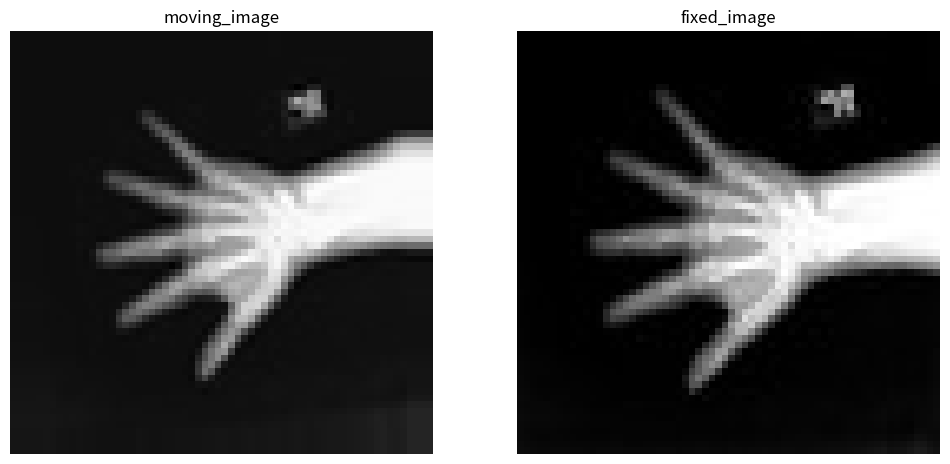

In [7]:
# 画像セット表示
plt.figure('check', (12, 6))
plt.subplot(1, 2, 1)
plt.title('moving_image')
plt.imshow(moving_image, cmap='gray')
plt.axis('off')
plt.subplot(1, 2, 2)
plt.title('fixed_image')
plt.imshow(fixed_image, cmap='gray')
plt.axis('off')

plt.show()

## 2. 学習
### 2.1 データセット, データローダ

In [8]:
train_ds = CacheDataset(data=training_datadict[:1000], transform=train_transforms,
                       cache_rate=1.0, num_workers=4)
train_loader = DataLoader(train_ds, batch_size=16, shuffle=True, num_workers=2)

Loading dataset: 100%|█████████████████████| 1000/1000 [00:01<00:00, 770.13it/s]


### 2.2 モデル構築

In [9]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GlobalNet(
    image_size=(64, 64),
    spatial_dims=2,
    in_channels=2, # moving and fixed
    num_channel_initial=16,
    depth=3
).to(device)

image_loss = MSELoss()
if USE_COMPILED:
    warp_layer = Warp(3, 'border').to(device)
else:
    warp_layer = Warp('bilinear', 'border').to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)

### 2.3 モデル学習

In [10]:
max_epochs = 200

In [11]:
epoch_loss_values = []

# epochループ
for epoch in range(max_epochs):
    print('-' * 10)
    print(f"epoch {epoch + 1}/{max_epochs}")
    model.train()
    epoch_loss, step = 0., 0
    # mini batchループ
    for batch_data in train_loader:
        step += 1
        optimizer.zero_grad()
        
        moving = batch_data['moving_hand'].to(device)
        fixed = batch_data['fixed_hand'].to(device)
        ddf = model(torch.cat((moving, fixed), dim=1))
        pred_image = warp_layer(moving, ddf)
        
        loss = image_loss(pred_image, fixed)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        
    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)
    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")


----------
epoch 1/200
epoch 1 average loss: 0.0617
----------
epoch 2/200
epoch 2 average loss: 0.0502
----------
epoch 3/200
epoch 3 average loss: 0.0474
----------
epoch 4/200
epoch 4 average loss: 0.0468
----------
epoch 5/200
epoch 5 average loss: 0.0437
----------
epoch 6/200
epoch 6 average loss: 0.0448
----------
epoch 7/200
epoch 7 average loss: 0.0433
----------
epoch 8/200
epoch 8 average loss: 0.0416
----------
epoch 9/200
epoch 9 average loss: 0.0418
----------
epoch 10/200
epoch 10 average loss: 0.0388
----------
epoch 11/200
epoch 11 average loss: 0.0397
----------
epoch 12/200
epoch 12 average loss: 0.0373
----------
epoch 13/200
epoch 13 average loss: 0.0369
----------
epoch 14/200
epoch 14 average loss: 0.0348
----------
epoch 15/200
epoch 15 average loss: 0.0347
----------
epoch 16/200
epoch 16 average loss: 0.0345
----------
epoch 17/200
epoch 17 average loss: 0.0322
----------
epoch 18/200
epoch 18 average loss: 0.0320
----------
epoch 19/200
epoch 19 average loss:

epoch 151 average loss: 0.0108
----------
epoch 152/200
epoch 152 average loss: 0.0104
----------
epoch 153/200
epoch 153 average loss: 0.0099
----------
epoch 154/200
epoch 154 average loss: 0.0112
----------
epoch 155/200
epoch 155 average loss: 0.0106
----------
epoch 156/200
epoch 156 average loss: 0.0109
----------
epoch 157/200
epoch 157 average loss: 0.0106
----------
epoch 158/200
epoch 158 average loss: 0.0105
----------
epoch 159/200
epoch 159 average loss: 0.0106
----------
epoch 160/200
epoch 160 average loss: 0.0112
----------
epoch 161/200
epoch 161 average loss: 0.0117
----------
epoch 162/200
epoch 162 average loss: 0.0111
----------
epoch 163/200
epoch 163 average loss: 0.0103
----------
epoch 164/200
epoch 164 average loss: 0.0103
----------
epoch 165/200
epoch 165 average loss: 0.0100
----------
epoch 166/200
epoch 166 average loss: 0.0105
----------
epoch 167/200
epoch 167 average loss: 0.0109
----------
epoch 168/200
epoch 168 average loss: 0.0111
----------
epoch 

### 2.4 学習履歴

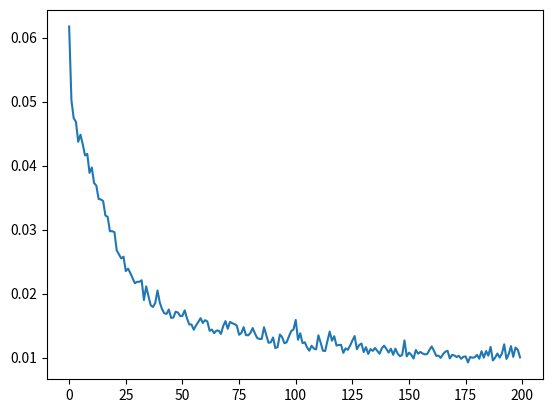

In [12]:
plt.plot(epoch_loss_values)

## 3. 評価

In [13]:
val_ds = CacheDataset(data=training_datadict[2000:2500], transform=train_transforms,
                      cache_rate=1.0, num_workers=0)
val_loader = DataLoader(val_ds, batch_size=16, num_workers=0)

Loading dataset: 100%|███████████████████████| 500/500 [00:00<00:00, 833.47it/s]


In [15]:
for batch_data in val_loader:
    moving = batch_data['moving_hand'].to(device)
    fixed = batch_data['fixed_hand'].to(device)
    ddf = model(torch.cat((moving, fixed), dim=1))
    pred_image = warp_layer(moving, ddf)
    break
    
fixed_image = fixed.detach().cpu().numpy()[:, 0]
moving_image = moving.detach().cpu().numpy()[:, 0]
pred_image = pred_image.detach().cpu().numpy()[:, 0]

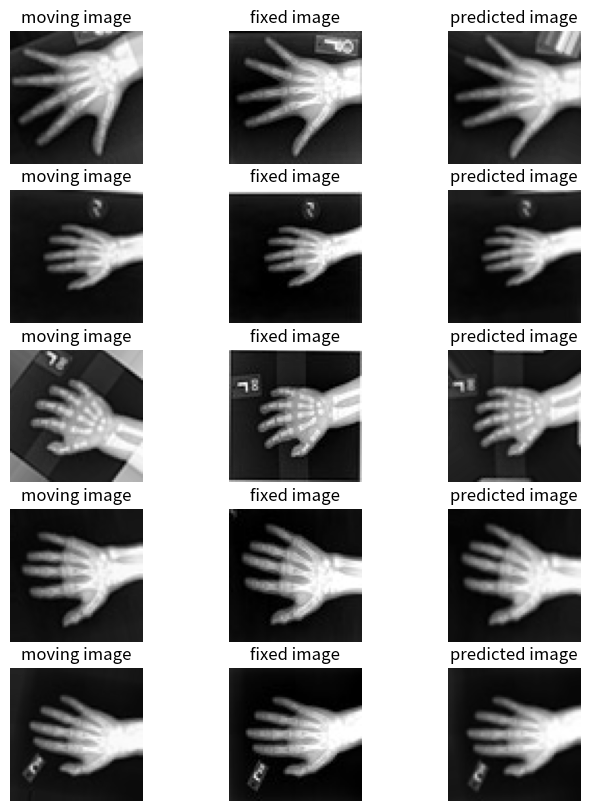

In [17]:
batch_size = 5
plt.subplots(batch_size, 3, figsize=(8, 10))
for b in range(batch_size):
    # moving image
    plt.subplot(batch_size, 3, b * 3 + 1)
    plt.axis('off')
    plt.title('moving image')
    plt.imshow(moving_image[b], cmap='gray')
    # fixed image
    plt.subplot(batch_size, 3, b * 3 + 2)
    plt.axis('off')
    plt.title('fixed image')
    plt.imshow(fixed_image[b], cmap='gray')
    # warped moving
    plt.subplot(batch_size, 3, b * 3 + 3)
    plt.axis('off')
    plt.title('predicted image')
    plt.imshow(pred_image[b], cmap='gray')
plt.axis('off')
plt.show()